In [1]:
import numpy as np
import pandas as pd
import psutil as ps
import os
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from Utility import draw_bitmap
import time

myProcess = ps.Process(os.getpid())
nb_feature = 5
nb_mdt = 479
split_ratio = 0.3
df = pd.read_csv('./data/train_sm_noise.csv').values

def load_data():
    train_df, test_df = train_test_split(df, test_size=split_ratio)
    X_train = train_df[:, 2:2+nb_feature]
    y_train = train_df[:, -1]
    X_test = test_df[:, 2:2+nb_feature]
    y_test = test_df[:, -1]
    #print X_train.shape, y_train.shape
    #print X_train[:3], y_train[:3]
    #print X_test.shape, y_test.shape
    #print X_test[:3], y_test[:3]
    return X_train, y_train, X_test, y_test

def load_pixel_data(nb_feature):
    df = pd.read_csv('./data/heatmap_pixel_1m.csv').values
    data = df[:, :nb_feature]     
    return data

# Linear regression
def build_lin():
    model = linear_model.LinearRegression()
    return model

# K-NN
def build_knn():
    model = KNeighborsRegressor(n_neighbors=3, weights='uniform')
    return model

# Random forest
def build_rf():
    model = RandomForestRegressor(n_estimators=100, max_depth=30, max_features='auto')
    return model

# Decision tree
def build_dt():
    model = DecisionTreeRegressor(max_depth=30)
    return model

# Gradient Boosting
def build_gb():    
    model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
    return model

#Kriging
def build_kg():
    #kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    #    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
    #model = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    kernel = RBF(length_scale=10.) + WhiteKernel(noise_level=20.)
    model = GaussianProcessRegressor(kernel=kernel, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=5, normalize_y=True)
    # parameter is from https://gist.github.com/paultsw/666711643442d8283252011a93b88241
    return model

# Neural Network
def build_nn():
    def create_model():
        model = Sequential()    
        model.add(Dense(512, activation='relu', input_dim = nb_feature)) 
        model.add(Dense(512, activation='relu'))    
        model.add(Dense(512, activation='relu'))     
        model.add(Dense(512, activation='relu'))   
        model.add(Dense(1))     
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model
    model = KerasRegressor(build_fn=create_model, epochs=1000, batch_size=32, shuffle=True, verbose=1)
    return model

def build_model(option):
    fmap = {'lin':build_lin, 'knn':build_knn, 'rf':build_rf, 'dt':build_dt, 'nn':build_nn, 'gb':build_gb, 'kg':build_kg}
    return fmap[option]()

Using TensorFlow backend.


In [7]:
model_option = 'nn'         # rf, nn, lin, dt, gb, knn, kg
iteration = 100
memory = 0
rmse = 0
err_mean = 0
err_std = 0
err_cdf = [0] * int(round(nb_mdt*split_ratio))    
hmap_z = [0] * (105*27)
hmap_test = load_pixel_data(nb_feature)
train_time = begin_time = end_time = 0
mem_rcd = []

for _ in range(iteration):
    X_train, y_train, X_test, y_test = load_data()
    begin_time = time.time()  
    model = build_model(model_option)    
    model.fit(X_train, y_train)
    end_time = time.time()
    y_pred = model.predict(X_test)
    hmap_pred = model.predict(hmap_test)
    
    testerr = sorted([abs(y_pred[i] - y_test[i]) for i in range(len(y_test))])
    err_mean += np.mean(testerr)       
    err_std  += np.std(testerr)          # first caculate std for each iteration, then avg all stds
    err_cdf  = np.add(err_cdf, testerr)
    rmse += (mean_squared_error(y_test, y_pred))**(0.5)
    train_time += (end_time - begin_time)
    memory += (myProcess.memory_info()[0]/2.**20)   # RSS in MB
    hmap_z = np.add(hmap_z, hmap_pred)
    mem_rcd.append(myProcess.memory_info()[0]/2.**20)
    
np.set_printoptions(suppress=True)    #suppress scientific notation
[err_mean, err_std, rmse, train_time, memory] = np.divide([err_mean, err_std, rmse, train_time, memory], iteration)
err_cdf = np.divide(err_cdf, iteration)
hmap_z  = np.divide(hmap_z, iteration)

print '------' + model_option + '------'
print ('mean:%f \nstd:%f \nrmse:%f \ntime:%f \nmemory:%f') % (err_mean, err_std, rmse, train_time, memory)
print ('total memory:%f') % (myProcess.memory_info()[0]/2.**20)
print list(err_cdf)
print '______Memory usage:______'
print mem_rcd

------kg------
mean:10.488521 
std:8.877608 
rmse:13.744372 
time:2.180375 
memory:227.531758
total memory:227.527344
[0.071934137531269329, 0.14588079948661986, 0.21861866474404706, 0.30395070728461238, 0.37887854820737815, 0.45949142519535341, 0.54364683089410404, 0.62210411529508602, 0.70354409585408295, 0.78490102080711666, 0.88043856596033265, 0.97738048415691525, 1.079545381322486, 1.1770593010704689, 1.297997990605644, 1.3860688014996065, 1.4927193074604554, 1.6166146226091671, 1.7452198611708623, 1.863556234667507, 1.9810160645876962, 2.0682802519739609, 2.1597623302162594, 2.2750900131370999, 2.4008068805027118, 2.494349472651495, 2.5901855487611205, 2.6877071527976879, 2.7810319047321501, 2.9095937483299128, 3.0128648267688267, 3.1035781119308354, 3.1968831473128621, 3.2987744461204627, 3.4068790625191547, 3.5148839688225451, 3.6146789933113102, 3.7161109306346014, 3.8063861623055844, 3.9134044924738123, 4.0233235387119768, 4.1188353908076092, 4.2348860072640706, 4.3509610307

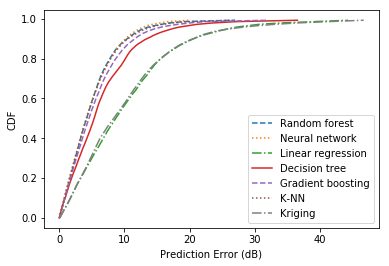

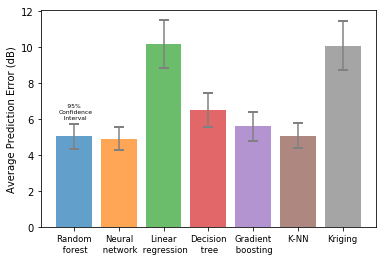

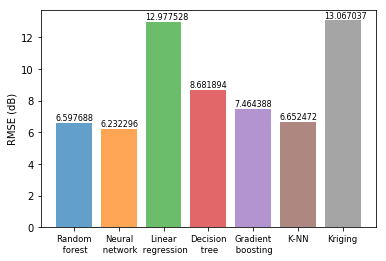

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import random as rd

objects = ['Random\n forest', 'Neural\n network', 'Linear\n regression', 'Decision\n tree', 'Gradient\n boosting', 'K-NN', 'Kriging']
"""
# sm_noise: 1st
means  = [5.057860, 4.921895, 10.181627, 6.499965, 5.620387, 5.097358, 10.087028]  # rf, nn, lin, dt, gb, knn, kg
stds   = [4.222874, 3.815341, 8.030555, 5.736062, 4.892460, 4.265185, 8.294912]
rmse   = [6.597688, 6.232296, 12.977528, 8.681894, 7.464388, 6.652472, 13.067037]
time   = [0.261085, 373.177970, 0.000576, 0.001003, 0.029075, 0.000359, 1.271086]
memory = [216.553633, 1648.010234, 215.296875, 215.128906, 213.613281, 218.710938, 222.474180]
cdf_rf  = [0.051638787878366267, 0.11464418458139562, 0.16228611223392109, 0.2209006133193045, 0.2744356633540504, 0.32746292315428532, 0.38549784010018739, 0.4488311976637524, 0.50028802353404067, 0.5516142859752341, 0.60846074523113602, 0.66845400933731214, 0.72722931600634222, 0.79308038148616555, 0.8500422147736626, 0.90254154912708262, 0.95280676224729177, 1.0180851109447782, 1.0713002983965054, 1.1360406390708575, 1.1926248938285808, 1.245316500510377, 1.2993686710299641, 1.3553622470010074, 1.4172051291875394, 1.4752138006185864, 1.5271112292962048, 1.5948740856600676, 1.6443352626945116, 1.6922470441243116, 1.745751624502327, 1.8050814283684233, 1.8656193937289984, 1.9246731108621347, 1.9778296325622009, 2.0293264840902561, 2.0891607873127547, 2.1447992854586961, 2.1918916011154255, 2.2437063771827739, 2.3061847212852125, 2.3600557728185549, 2.4300917581874848, 2.4771129712068274, 2.5308170148090774, 2.5845756297831031, 2.6367134677512691, 2.6979402839494924, 2.755335904720642, 2.8204698190001629, 2.8773176437221148, 2.9320242712583151, 2.9800688808512046, 3.0360341420363222, 3.0903538610725665, 3.1487533223564923, 3.2087233642151536, 3.2704718138914148, 3.3234512169179675, 3.3758002351077585, 3.4403739728617517, 3.5021564088592383, 3.5655761034560691, 3.6312277927900447, 3.702346372153571, 3.7710861114785859, 3.8220015474636697, 3.8874723766175507, 3.9494797810650231, 4.0176104305652878, 4.0798118192394401, 4.1416321932105582, 4.20818304986269, 4.2784337937956813, 4.3469583811100474, 4.4186579371224859, 4.4852238634508046, 4.5568548131315154, 4.6173665622890923, 4.6885583367833199, 4.7573615927357134, 4.8211958609082357, 4.8765862834336708, 4.946670620249785, 5.0097472825723353, 5.082106868864491, 5.1616563073278314, 5.2333999997243703, 5.3020204052629154, 5.3846015718790241, 5.4493124849121592, 5.5310741277108768, 5.6134646448129173, 5.6825315542233339, 5.7459446723224996, 5.8133005335650116, 5.8887444052508586, 5.9559123726712331, 6.0370945080745795, 6.1206950808133804, 6.2026378198969834, 6.2887687003695181, 6.3545990662087277, 6.4231891705996853, 6.5266704071879609, 6.6259196654462604, 6.7174221499770468, 6.8363187858234076, 6.9467209868159072, 7.0340711002793981, 7.1534740012829392, 7.2812057255029563, 7.409398666546724, 7.5224389384714199, 7.6434317307079889, 7.7760784676208452, 7.8888548672535732, 8.0189906222768634, 8.1599745422810468, 8.2891255432990221, 8.4127817313905275, 8.5541766402044743, 8.7226717892408931, 8.9123955005274258, 9.1295090446941956, 9.2883266844026178, 9.5106278330560414, 9.7339123760456125, 9.9860900249005873, 10.282847697567297, 10.558343808910045, 10.850516194057761, 11.123646277983617, 11.419840720507336, 11.746447627112001, 12.130396289429974, 12.506120861890031, 13.023872363164497, 13.643592497604688, 14.493630755175234, 15.626606507000279, 16.896502601345837, 19.079517929141691, 27.006303311115165]
cdf_nn  = [0.055949399313929858, 0.10712091931766012, 0.16340176041279683, 0.21334186994130083, 0.25685463714347212, 0.31150174356886678, 0.35997213360821328, 0.41295511171929705, 0.46540728233870654, 0.52276591204907374, 0.56868676418311326, 0.6248889719172197, 0.67519577059604141, 0.73466080539665068, 0.78351706383271702, 0.82800422200392176, 0.87504076580620127, 0.9342655242023945, 0.9869266154831835, 1.0369416293141169, 1.096183802613957, 1.1500580143761667, 1.2074945533693553, 1.2598575064278656, 1.3150496998760528, 1.3707825591945366, 1.4225117895608645, 1.4768711096520213, 1.5374161718229962, 1.5949846399917187, 1.6519263441743441, 1.7072705264102586, 1.7665568709450481, 1.8152867372118617, 1.8825746922908826, 1.9378591115451649, 1.9962164176661934, 2.0601534272339421, 2.1137762635217974, 2.1684489624663943, 2.2154857473631262, 2.276364391237665, 2.3358733833354086, 2.3978737352196875, 2.4579625729851053, 2.5174971335716387, 2.5806220943227269, 2.6345616610830076, 2.6898385237577007, 2.7553822620775095, 2.8140423682257083, 2.8738852111269853, 2.9316056145984613, 2.99473566116529, 3.0598012711575162, 3.1236414128123813, 3.1832403998313539, 3.2363315664629342, 3.291914285238335, 3.3485817853793209, 3.4096448023545993, 3.4688353789490458, 3.5338301445365086, 3.5833711960352126, 3.6509134161252526, 3.7153070535892154, 3.7824562798991472, 3.8439916291475846, 3.9110973110251233, 3.9792916190388534, 4.0412262166062822, 4.1087114020790798, 4.1624456879316112, 4.2324263170384153, 4.2941626159143595, 4.3577473860865892, 4.4154329645534682, 4.4829690450671213, 4.5596420292283515, 4.6262600860664653, 4.6878110548099237, 4.7710082703914027, 4.8435613769652575, 4.9144003550598754, 4.9924949009915744, 5.0660103694547374, 5.1477036538180467, 5.2222552808160856, 5.2964996719869539, 5.3812394595202129, 5.4569666479942374, 5.5444269845102951, 5.6195541345540141, 5.7058057250696983, 5.7853981427259296, 5.8795687706023747, 5.9588530977537486, 6.0518000766019995, 6.1268118998598489, 6.2252300658773114, 6.3171889776999919, 6.4235305939068086, 6.5115623484752554, 6.6063545323118795, 6.6943485976353614, 6.7838008006708765, 6.8958191458585691, 7.0176279561266117, 7.112068604336411, 7.227545346902124, 7.3213965396357912, 7.4224086265490197, 7.5328240296624323, 7.6174206128483126, 7.7313443248736871, 7.8486114826011315, 8.00080835672631, 8.1161417816318817, 8.2590336905420436, 8.3830943576940005, 8.506180139935573, 8.627703611400042, 8.7560216435428693, 8.8932925240341927, 9.086174240145116, 9.2786718687210037, 9.4589077720380637, 9.6239891636081953, 9.8560276382109002, 10.073201686619438, 10.293510931110989, 10.512039240139984, 10.764313831069737, 11.068065357031427, 11.359957155162649, 11.649937903381424, 12.028035493758045, 12.437082830568192, 12.928443909480713, 13.409566547270236, 14.255348310549515, 15.500848111356255, 16.696037374635136, 19.86155181113044]
cdf_lin = [0.11747897986591312, 0.21810856205463516, 0.3340600940181821, 0.42734013342317262, 0.55173080292486354, 0.67327499846105676, 0.79983924116947891, 0.93337679363722525, 1.0411217283015874, 1.1435867906242354, 1.2579460171371155, 1.3851232481252, 1.4986057804519113, 1.6078718823046707, 1.7093650733684458, 1.8328302095122171, 1.9288169645624444, 2.0403691625136191, 2.1511175376705571, 2.2438008126918185, 2.3509675053212731, 2.4589557042085843, 2.5588318225148319, 2.6512266225695909, 2.7503323630556986, 2.8765257719697761, 2.9920389185688485, 3.1298195978398344, 3.2402130763691281, 3.3398816528158544, 3.4492119069026739, 3.5754318770047386, 3.6968185348249811, 3.8275431206612525, 3.9273356429368893, 4.0517736099606658, 4.17478520424386, 4.2901029643381126, 4.406515317724077, 4.529755941876628, 4.6502749086190223, 4.7619492715665608, 4.8832496263392073, 5.00031165706317, 5.1212176908073168, 5.2352960448998633, 5.3578471466781448, 5.483510919550441, 5.6175596270427066, 5.7416541537367607, 5.8713049998203211, 5.9933258192301864, 6.1117433003019768, 6.2191038743512692, 6.3510346306629684, 6.4732042928858906, 6.5919911954179735, 6.7192045662524675, 6.8371768312636627, 6.9710201324900698, 7.0799741537950815, 7.2069413554093602, 7.3133668625219874, 7.4416706177432346, 7.5843355232637828, 7.7127931511366503, 7.8422743799687389, 7.9987009127425379, 8.1442217708743279, 8.2786787898477172, 8.414519790688237, 8.5430005908437927, 8.6775300650613829, 8.8185493725130968, 8.9614452673474254, 9.1197283467536074, 9.235854858609418, 9.3879107473564947, 9.5189078920088654, 9.6743283044967114, 9.8201991933534849, 9.9834867432526568, 10.123359709556567, 10.264093320891538, 10.402533140161601, 10.56562052648199, 10.724233482747414, 10.877261959362798, 11.006343835599253, 11.154679966004943, 11.335838517086822, 11.527288933806499, 11.69294188282362, 11.842309765896209, 11.982893453667636, 12.15172583498283, 12.293605653851381, 12.436199432396801, 12.591120303246585, 12.736529977147718, 12.870252120555767, 13.072837589298128, 13.218385131828024, 13.43493636902998, 13.570242612326266, 13.720498616518464, 13.870015294064695, 14.040351320807394, 14.205834323233178, 14.374178514150172, 14.531077635052386, 14.69495829434881, 14.899970389195897, 15.068426001161493, 15.283537308696777, 15.517821617890192, 15.7406349915021, 16.017714880338417, 16.268476432087933, 16.546686557298177, 16.865981741766277, 17.246644445712413, 17.534241428462607, 17.892280624849192, 18.203368120619736, 18.576052148617805, 18.996905770422742, 19.399346567327587, 19.857365379448421, 20.316897289782929, 20.814244515041135, 21.357107547722457, 21.927138115194822, 22.706435936978551, 23.47574143984582, 24.244964103448098, 25.191850391125612, 26.070336427166851, 27.163859576212658, 28.815149073029083, 30.611924147603627, 33.894799848257279, 39.131801877052496, 44.280263359364355]
cdf_dt  = [0.043054437802996226, 0.098016667640998381, 0.14547569282699996, 0.1974111339950021, 0.23972988166200188, 0.29702381752000195, 0.35105966323300009, 0.41127725869300064, 0.46849606473400074, 0.53837114219700011, 0.61809443987999924, 0.6835550511199987, 0.75919208736499944, 0.83428030379699947, 0.90373009628999956, 0.98591700622200051, 1.0547458986820002, 1.1229322344999992, 1.1756425621939997, 1.2438787041429995, 1.3068743000510006, 1.3692162368180008, 1.4308035025170012, 1.49609759864, 1.5658864886370012, 1.6445208011280004, 1.7245770727440002, 1.7902129394919999, 1.8661964907930013, 1.9375340870020015, 2.0110595752510005, 2.0839401668930013, 2.1665563380319992, 2.2585045423290002, 2.3427903343730008, 2.4258567041770012, 2.5105822073730009, 2.585630084315, 2.6615001461230001, 2.7294742680540018, 2.822961638552, 2.8945864003140014, 2.9726834494159995, 3.0576570530639988, 3.1443627537129997, 3.2236006129299999, 3.3096039671390001, 3.3904490479570004, 3.4641897037129978, 3.5475642519470005, 3.6195011393699987, 3.7158414074339992, 3.804002247943, 3.8916201490959974, 3.9757771804019995, 4.0715300585979994, 4.1552102864170006, 4.2343322108730019, 4.3119158779359985, 4.3997093490940005, 4.4689289315249976, 4.5549776595130007, 4.6352550230140022, 4.7187296329109989, 4.7959806855439995, 4.8733176342640023, 4.9533526486239987, 5.0219005418710019, 5.1027342491590026, 5.1740330818189966, 5.2370397254789998, 5.3061819170370015, 5.3761243486149999, 5.4524994477730004, 5.5139682833149992, 5.575180532239, 5.6393584843720035, 5.7131192329159992, 5.7748357967129982, 5.8355982303179985, 5.9025374273090048, 5.9671159657060038, 6.0418069190220001, 6.1126452338050008, 6.1979569026909989, 6.2794458187340014, 6.3511888667059972, 6.4365551087600013, 6.5252653231970017, 6.6122375432880025, 6.7248307561109968, 6.816537682056004, 6.9010765982819979, 7.0051197888330012, 7.1005455107989954, 7.2067497298000021, 7.3341421496950003, 7.4420613586719995, 7.5587017578450029, 7.695023700318, 7.8575795976620029, 7.9933197175439989, 8.1438190841409952, 8.3059264331449985, 8.4759919761989995, 8.6137989864539968, 8.8015307130019984, 8.9435190453509978, 9.1194238601859983, 9.2934044029079992, 9.4708295603530015, 9.6118117959169957, 9.7438333586839985, 9.8885541546579994, 10.012683692524996, 10.142506181150999, 10.251272181792, 10.380862034083002, 10.522585145799992, 10.658854039836998, 10.812811011617999, 10.986602542773992, 11.178617309410001, 11.405589316261, 11.625302187491002, 11.870595558955999, 12.170482346842002, 12.500639887084992, 12.808223431448001, 13.181334888471, 13.618830694691997, 14.072643882402991, 14.450434153787992, 14.954820517762993, 15.462757470410997, 16.073204067121004, 16.757574664138005, 17.473492926297002, 18.38458367167901, 19.723586942438011, 21.079179032334995, 23.429377968828998, 27.186489266179983, 36.53425587377302]
cdf_gb  = [0.053482238253331718, 0.12517413118068454, 0.18523240593533521, 0.24845371299285055, 0.29335671209979697, 0.35407971778566372, 0.40270943991203517, 0.4639774210080318, 0.53862715008017648, 0.59241119455437252, 0.64766393975496528, 0.70318929675651087, 0.76352056526849521, 0.82424251359148359, 0.88276858068827468, 0.94370551930615643, 0.99701588901811899, 1.0595852038331512, 1.1207249815309261, 1.1664737001063117, 1.2367138671181492, 1.3005382858482346, 1.3536071611463156, 1.409562214392077, 1.474758813613966, 1.5363491354805978, 1.592925971919084, 1.653171180591245, 1.7108432897041856, 1.7679851349388269, 1.8261124894380141, 1.8957441733226006, 1.9595930538247672, 2.0139499541108536, 2.0716392328179407, 2.1374205302651563, 2.1858220670241888, 2.2505795611382, 2.3159752418248836, 2.3907798599333159, 2.4560784299896703, 2.518410919719333, 2.5859808649172749, 2.6434001900083626, 2.7016384773974784, 2.7641579963497453, 2.8309300771047776, 2.8982604147500717, 2.9581090663078555, 3.030095488232218, 3.0930497123056737, 3.1510195673806352, 3.2173442883470322, 3.2791635852998731, 3.3399411854736583, 3.4097582203425945, 3.4684337246406098, 3.5312096856698405, 3.6021898649088167, 3.671649339351609, 3.7460042301232721, 3.8101588743914037, 3.8822946965923246, 3.9482993623736649, 4.0180775650306551, 4.0812955444168653, 4.1516162669765047, 4.2246909365628351, 4.2916624498004987, 4.3578706656729675, 4.4321267481430331, 4.5177131307251077, 4.593834288531319, 4.6641598389721466, 4.7324204548634556, 4.8001215202374592, 4.879580192027583, 4.9474526580574381, 5.0186492779301561, 5.1071780673624918, 5.181501409883098, 5.2552866987114282, 5.333969725045093, 5.4051827651237829, 5.4823538707574722, 5.563849757515678, 5.6433616450736546, 5.7294688829889626, 5.8163019487649414, 5.9124589494101585, 6.003662914471831, 6.0847272093400155, 6.1532281896153265, 6.2413300969386452, 6.3184455737455387, 6.408672454254976, 6.486126470341981, 6.5856257595078809, 6.6678916002287245, 6.7651434424464743, 6.8509171473781318, 6.9590731668420425, 7.0645037715586838, 7.1609250794569235, 7.2822426947679455, 7.3993797153167691, 7.513303515301371, 7.6472545320664969, 7.7582556905800377, 7.8854641421148406, 8.0019941342775436, 8.1293314046531506, 8.2653395048086811, 8.3818748267026706, 8.5184073948702146, 8.6785132242340008, 8.8335801886509095, 8.98044224385219, 9.133661672597901, 9.2862028768023546, 9.4730875672060115, 9.6102345313710185, 9.7858227340111039, 10.019613715019565, 10.196783781983378, 10.403353021188396, 10.647224574455556, 10.914517043744608, 11.187150182218113, 11.442572785094601, 11.7358514554822, 12.001794290809022, 12.32887939808943, 12.646561983602812, 13.09535604317171, 13.576431356638643, 14.1547006358103, 14.758849671845548, 15.671019576107961, 16.740790356431084, 18.145264717545743, 19.944289082868057, 22.352275842944824, 31.9275444392376]
cdf_knn = [0.060918360235664437, 0.12051162825033358, 0.175939217020668, 0.22683251462033532, 0.2819857620250007, 0.33299322274233534, 0.38373071233366818, 0.43367360248633452, 0.48473042025233454, 0.53673341691066656, 0.59130227032900107, 0.64570062665966732, 0.69867418858566777, 0.75078052933400041, 0.80254669525699984, 0.85234283693999902, 0.89826293769866683, 0.94750954266133292, 1.0074721438719989, 1.0609936735026668, 1.122705398527335, 1.1685473469499998, 1.229120494303334, 1.2922712675636661, 1.3573538839279993, 1.4087236257066678, 1.466081490829668, 1.5137845557846674, 1.5678269655330019, 1.6267898609520008, 1.6949263293443328, 1.7488875373666659, 1.810644485239, 1.8678924832709993, 1.9168766544696678, 1.9836118512756662, 2.0386578128176667, 2.0934677815373335, 2.1512277367176678, 2.2091047193133337, 2.2615730323266678, 2.3238704680253339, 2.3858472305233325, 2.4409381014363341, 2.4942950814926665, 2.5519566918023329, 2.6128156803140006, 2.6760277799343313, 2.731295486811665, 2.7866418630693319, 2.836900180314998, 2.8897112822503321, 2.9489044513063329, 3.0168560889913327, 3.0664053902266657, 3.1344137518876658, 3.1913203719623326, 3.2467125943893338, 3.3049949042363322, 3.3710717949839988, 3.430500128305999, 3.486931776419667, 3.5504768472933339, 3.6183156467146667, 3.6722849741303314, 3.7493794621689993, 3.8229811211453328, 3.8940939238279988, 3.9628305329543347, 4.0336327477246643, 4.0979839697856644, 4.1641392832979962, 4.2280218631366662, 4.2962177724223336, 4.3629302022259999, 4.4277281126529973, 4.482207312142668, 4.5564915724059976, 4.6366447275706637, 4.6976816246683351, 4.7798009778843298, 4.8476607080193306, 4.9148506982600004, 4.9848073685329988, 5.0467244329719971, 5.1189939476533359, 5.1904911272419998, 5.2562827374473349, 5.3299599876456663, 5.4044320651743343, 5.4778953621460005, 5.5474544876709979, 5.6366681766139983, 5.7146923052466629, 5.7861046574620012, 5.8511755702363359, 5.9162945315063311, 5.9884661515746664, 6.069472096721336, 6.1566407176579991, 6.2246820218509944, 6.310067203268666, 6.4188512196833303, 6.5079328184536642, 6.6099889403413314, 6.712327507103331, 6.807478749489337, 6.8981159940010004, 7.0066961136163339, 7.1183352709583323, 7.2625660482706653, 7.3914085554946656, 7.5115444705169985, 7.627300627069336, 7.7618208710830006, 7.8807244883616683, 8.021028997798334, 8.1705251497603317, 8.3080202022336689, 8.4568461251569982, 8.5961742333279965, 8.7470082013346691, 8.9281508129729996, 9.1282952227306673, 9.2932495477950017, 9.4845939599716651, 9.6832626441686696, 9.9258044653063315, 10.138223509929666, 10.367100497445662, 10.657802947264999, 10.946830961536, 11.273696323832333, 11.694297536242669, 12.051461419282331, 12.47647334506633, 12.910669217091673, 13.534912613021003, 14.151003189315668, 14.92221738053666, 15.884868178892997, 17.196133444666668, 19.796245524280334, 26.199722548175014]
cdf_kg  = [0.11742454116780422, 0.23856759418847312, 0.34542878352587286, 0.46574591339386751, 0.57613540820047904, 0.68735382029310554, 0.78068901865712714, 0.90369365169904625, 1.0383778119221168, 1.1595403727052405, 1.2822320537889491, 1.3959212665167564, 1.4975201240969509, 1.605711284591153, 1.7145349069844074, 1.821731342792424, 1.9191304566605618, 2.0160592599769522, 2.1319966631656406, 2.2398727803297227, 2.347484987348103, 2.4354676440970149, 2.5252668972373749, 2.6238972436712777, 2.7331382663753687, 2.839794484729647, 2.9529332779454993, 3.060924247074007, 3.1828783038723736, 3.3087244141985979, 3.4342265784659891, 3.5294226420597101, 3.64515720728506, 3.7667263248799769, 3.8675611034011967, 3.9847870120769402, 4.0832563372790496, 4.1957980934999854, 4.3024899430037689, 4.3966875815095605, 4.5028475212273769, 4.606055450053387, 4.7093725336475458, 4.8175387134075383, 4.9233055075951802, 5.0284245182394844, 5.1222190030779053, 5.2099566404336688, 5.3083864596440158, 5.4199670098220283, 5.5135217935726182, 5.6079227846667417, 5.7127348893786198, 5.8173679513665375, 5.9206141195912521, 6.0136757561697189, 6.1096226482597151, 6.2279205722872151, 6.3545062370467669, 6.4730886095912954, 6.6014621436171046, 6.7435255291913272, 6.892257175296816, 7.0362365299478027, 7.1767424544628113, 7.2918121480556399, 7.435688861149611, 7.5714600867621229, 7.7153411720641714, 7.9107569325863878, 8.0628079531574812, 8.206384457260965, 8.3767951410749841, 8.5405840887558764, 8.6706757588744363, 8.8252450188455551, 9.0073602481215715, 9.182342032677548, 9.3325786607301033, 9.4620724484092928, 9.6158890262029093, 9.7536288866116116, 9.9005433699159369, 10.068595879567781, 10.215178067595422, 10.360425220397946, 10.486229866366262, 10.621998719591739, 10.753867701253389, 10.889925250574517, 11.033048128442486, 11.20794880731135, 11.339394845408997, 11.477985747225702, 11.65970353892876, 11.801022291033854, 11.965573892097035, 12.10544462207806, 12.262824497046802, 12.408320827949328, 12.551971648634346, 12.714566494915418, 12.902143317717776, 13.038919848728339, 13.204834279219394, 13.402908752151074, 13.629379106507974, 13.788997511209509, 13.952090901646343, 14.166855033231016, 14.351043880067284, 14.570204094115912, 14.815746261285337, 15.048605640654351, 15.326353609059836, 15.597622463615252, 15.833227938020963, 16.05545764452226, 16.339677037783062, 16.607821592928509, 16.834961480184791, 17.139438746767986, 17.436999368780388, 17.768658515287918, 18.104437081673076, 18.476640183234885, 18.838953407105741, 19.297581204460581, 19.739380691032512, 20.199299499862697, 20.783362584732771, 21.232402221745261, 21.814785228258337, 22.356030827070366, 23.116762504150572, 23.931265743254972, 25.067122579631992, 26.512679228768356, 28.165336884596751, 30.256820166616627, 32.93392986335661, 36.257373922155509, 41.157432896083485, 46.688903080439843]
"""

# sm_noise: 2nd
means  = [4.219746, nn, 5.588665, 5.447493, 4.107779, 4.407631, 5.727079]  # rf, nn, lin, dt, gb, knn, kg
stds   = [3.262751, nn, 4.179920, 4.151399, 3.199810, 3.293837, 4.202693]
rmse   = [5.336396, nn, 6.981495, 6.851142, 5.208860, 5.504224, 7.105657]
time   = [0.268946, nn, 0.000988, 0.001182, 0.025683, 0.000402, 1.195196]
memory = [216.458320, nn, 217.816406, 215.910156, 240.152344, 213.726562, 222.845430]
cdf_rf  = [0.048929748038551962, 0.093616199722793711, 0.13393434989863606, 0.17390104230138589, 0.21387365391643059, 0.25809644454089864, 0.30144588055285143, 0.34367811174213786, 0.3872542693762806, 0.43536576558286499, 0.48281816887877399, 0.52630061530361483, 0.56508347129666969, 0.60261022216896476, 0.64654068723089919, 0.69010202980531266, 0.73272922409685903, 0.77409479752357824, 0.82653506263738175, 0.87338158162163748, 0.92064924857023778, 0.96576103954807113, 1.0097340098730452, 1.0585892076806043, 1.1017081935533299, 1.1433572404444656, 1.1863586645469217, 1.2325027739903545, 1.2753712930831222, 1.3122900024242392, 1.3505340854094994, 1.389774905046937, 1.4361133123403176, 1.4788956980050119, 1.5240009193352524, 1.5816058472480818, 1.6300213613820558, 1.6776444990098947, 1.7313954563981786, 1.7802789115574758, 1.8239807946461277, 1.8779496427267361, 1.9200761534941955, 1.9746622362027226, 2.0213290976625276, 2.0664769587831167, 2.1093589226350802, 2.1598600737844764, 2.2128128098052056, 2.2621054652685357, 2.3143761888150527, 2.3601744519883043, 2.4089600962037285, 2.4547254511195846, 2.5032813380212184, 2.550598966474614, 2.5990150512300136, 2.6575793609562526, 2.7120059706238546, 2.7646337555721736, 2.8297645634982835, 2.8855596929005514, 2.939210945447519, 2.9964820761219242, 3.0533400183351813, 3.1154047750975202, 3.1738399031575373, 3.2326577140270376, 3.2863273117151675, 3.3371069211812916, 3.3983633487958174, 3.4582430213280859, 3.5244291385737387, 3.574905111081772, 3.638680594556281, 3.6992726247536734, 3.7627809926783122, 3.8244744807656299, 3.8872184855014758, 3.947464616205663, 4.0080014247420488, 4.0765164014723476, 4.1458297178393479, 4.2175205804880287, 4.2846371355306534, 4.3457801555327622, 4.4108287511415947, 4.4805979067067359, 4.5532421183994245, 4.6244432489409952, 4.7056908240619206, 4.7735581514769754, 4.8450971513764554, 4.916452409367154, 4.9922258506811614, 5.0726569438599665, 5.1393129418695116, 5.219482316272555, 5.3048756280832574, 5.3821572189368512, 5.476903069529329, 5.5666406463082252, 5.653674469203902, 5.7362672018999294, 5.8358067624670609, 5.9197837231313057, 6.0108485287326099, 6.1181660974508132, 6.2228803750367616, 6.3207579175031761, 6.4313810221121921, 6.526366634988217, 6.6218120350234662, 6.7241958427073554, 6.8255968407437022, 6.9552264854828421, 7.0772512194568797, 7.1869592268456302, 7.2953959248317544, 7.4083361736044502, 7.5190883857499315, 7.6564494822612748, 7.7848125453713362, 7.9126530195560658, 8.0532200849412554, 8.1859926358876685, 8.3359722848306461, 8.5101540686330939, 8.6721517703194966, 8.8487055687261833, 9.0115189557902688, 9.1879399463162184, 9.3854908168341833, 9.6330624702249352, 9.8798519343557079, 10.128952479694227, 10.40856301351705, 10.803579327407283, 11.14439679587521, 11.626492047817885, 12.209460803974569, 12.853294217612291, 13.886611460420598, 15.375454062099065]
cdf_nn  = []
cdf_lin = [0.068611790064456807, 0.13774009465002152, 0.20224724615439571, 0.26989302395060349, 0.33608665775289892, 0.39081747426921354, 0.45661490578333896, 0.5184030985454362, 0.58187989008613783, 0.6430152871407766, 0.69675470951292284, 0.75390426465646532, 0.80512276525246418, 0.86104743225053415, 0.92258477649676052, 0.97978203876480852, 1.0426809573729934, 1.1028584267735524, 1.1554309773410245, 1.2105491544283387, 1.2787156988252701, 1.3319763090090542, 1.3946629655327325, 1.4455718511157423, 1.5013061679582547, 1.5647548181173301, 1.6215665387790228, 1.6742451551035933, 1.7359997846265016, 1.8076786981872837, 1.8742705610381813, 1.9344065519729066, 1.9948679832745648, 2.0535152328797195, 2.1245289671052676, 2.1806774941219818, 2.2484670795140711, 2.3085445198683674, 2.3610799291020625, 2.4233361188116933, 2.4844465730319105, 2.5544400339423925, 2.6147230320921073, 2.6786333857690856, 2.7347604007050408, 2.7931913755054465, 2.856189647617744, 2.9286068850493496, 2.9946638118606979, 3.061848381502172, 3.1348724102826848, 3.2077656279584379, 3.278648536544436, 3.3565923010945342, 3.4362198452274813, 3.5055302610857302, 3.5786423505920903, 3.6482014534471934, 3.7195912751133653, 3.7847636509243832, 3.8661827653543628, 3.9332465655627336, 4.0098387453801818, 4.0868620162190448, 4.1687464659058442, 4.2504874045658934, 4.3290979835680217, 4.4071024728881545, 4.5016955485174446, 4.5820009676228199, 4.6732485072357726, 4.7596501240441196, 4.8540934204879251, 4.9461928554541217, 5.0275814953041769, 5.1141224544088395, 5.1811326791165424, 5.2804453687500859, 5.377572245588369, 5.4694130116523745, 5.5481851427045772, 5.6271840903949126, 5.7125678866360294, 5.7944853675172601, 5.8712740617144297, 5.9544003806522632, 6.0490751422502491, 6.1159396106715977, 6.2002832066, 6.2708626090852571, 6.360072078717554, 6.4515176270460248, 6.5438146432469555, 6.6378458106844276, 6.730439124266649, 6.8423594682299678, 6.9416117202410259, 7.0425691713388892, 7.1301269581978568, 7.2324655990961855, 7.3374993609839585, 7.4488655292310693, 7.5555866314943909, 7.6731060193595546, 7.7732357931072622, 7.8838634244446073, 8.0016739319386545, 8.1095467803095502, 8.2125962591839556, 8.3221378451904524, 8.439875378586466, 8.5463144477442636, 8.660887413618422, 8.7764440562178923, 8.8898624318996831, 9.0268010797232563, 9.1533892805004324, 9.2747035002962583, 9.4106495056744013, 9.5644751450203991, 9.7193803990267718, 9.8564054906209133, 10.001014126477765, 10.150562124602171, 10.302684019765115, 10.469798834945962, 10.644765461275197, 10.81681654442106, 10.99269535017353, 11.174985921497639, 11.360443826654922, 11.583875839539497, 11.8616110260458, 12.141157990481524, 12.537982130626133, 12.898334710952653, 13.42029233099537, 13.962470294582726, 14.530936871135225, 15.033497786446974, 15.854175573566261, 16.7638970819613, 17.977337899367768, 20.426778455737175]
cdf_dt  = [0.076362078979998957, 0.1343908622580004, 0.18377403278600241, 0.23805860837100071, 0.30563646079000151, 0.36198917598600017, 0.41881420480300263, 0.48390219081099944, 0.54120387853300056, 0.59632783790400168, 0.65448143225499977, 0.71093010851700034, 0.7653363263330013, 0.81644341836099998, 0.86703387433599988, 0.92150282187100085, 0.99089245254600056, 1.0557373328869999, 1.118070831872001, 1.1885101079580003, 1.2616501140640011, 1.327129109841001, 1.3837927363090001, 1.4490905152089995, 1.5084665990380006, 1.5740145573209992, 1.6449139032829996, 1.7229030725320009, 1.7882293941790015, 1.8535078530370026, 1.9150512270559992, 1.9795623618360008, 2.0299598228450013, 2.0899236122690015, 2.147331056446999, 2.1992863822299968, 2.2461175157089981, 2.2954343716469996, 2.3360280482500007, 2.3748150312249998, 2.425327533655, 2.4787367717030016, 2.526952795869998, 2.5773919182769993, 2.6286547874190003, 2.6827849685380021, 2.7311514431519988, 2.7939723988660012, 2.8537918968830014, 2.9108572929180001, 2.9734879371640002, 3.0395897112380021, 3.1016121306610018, 3.1726568673009981, 3.239019152664, 3.2952337180970015, 3.3632114849789998, 3.4296952326179992, 3.5056100604780012, 3.5852163884469981, 3.6648013432439974, 3.7357883319429992, 3.8098870477319982, 3.8841286434789981, 3.952213897877999, 4.0219849482449996, 4.0890393749079985, 4.177111060260998, 4.2502539325290023, 4.3271488189109997, 4.3927896179110011, 4.4697885630399998, 4.5461108467819988, 4.6292874574689993, 4.7077891105490002, 4.7934650984579985, 4.8611266168920002, 4.9377119215299965, 5.0246935827229997, 5.1180592153709998, 5.1911834127320002, 5.2847563063659981, 5.3597761833550006, 5.444495345101001, 5.5188508413980006, 5.5945267604739994, 5.6803282133530004, 5.7834158709060013, 5.8829461821289986, 5.9952189462159966, 6.1109317545400037, 6.2008867026730004, 6.292235183659999, 6.3858168653599989, 6.4853176678870001, 6.5853428862920005, 6.6946439045719979, 6.7937943705789987, 6.9178806191110018, 7.0302189637239998, 7.1398577862769965, 7.2545919038519973, 7.3671510696859972, 7.4855861489140008, 7.6128348580630005, 7.7284395492800035, 7.8507730856049998, 7.9580429118849985, 8.073414795174001, 8.1814374738969988, 8.3014380998030042, 8.4240550560909995, 8.5358904990090032, 8.6492551705990017, 8.7755587815960006, 8.8880110305129989, 9.0233044004239993, 9.1397988127559984, 9.2652359694510036, 9.3861600706240047, 9.5136851902570019, 9.6510907781980002, 9.7963608912960041, 9.9556327559090025, 10.102952951368, 10.292248999287999, 10.467853158470005, 10.698463243069998, 10.905051482398003, 11.149301878192995, 11.417962231864998, 11.688719442150996, 11.975624714027997, 12.284926903810003, 12.568535903721999, 12.944794589027998, 13.331605422784996, 13.709283897617995, 14.204590914958997, 14.779848853960997, 15.58142228685, 16.713044938211006, 18.240276655630005, 19.927503455087997]
cdf_gb  = [0.033599597482229203, 0.078649239011373592, 0.11518234988569091, 0.16305728933458866, 0.20459188623959038, 0.24601962681885284, 0.28623207828261316, 0.32136133692479518, 0.36650299552599436, 0.40416104596161234, 0.44507227896298118, 0.49250654392540466, 0.53407973672688214, 0.57169435651033684, 0.6183521771377879, 0.65002404831767402, 0.68761836947854083, 0.72744192389294637, 0.76396726741795273, 0.80438991659374925, 0.84621637445717979, 0.88956405482151724, 0.93218058818087901, 0.96734406684391527, 1.0151881116013453, 1.0576673643089645, 1.097531319812733, 1.1377443881168809, 1.1891936200106226, 1.2301168094650454, 1.2694332004046265, 1.3097239737797712, 1.3580974378979005, 1.4035280082938379, 1.44281178853971, 1.4899099832802962, 1.5362209477120465, 1.587135251372465, 1.6370335658487332, 1.6813499398755647, 1.73665725818822, 1.7889385760453325, 1.8364804136641952, 1.8823152487656107, 1.9366919140121299, 1.9818658279142534, 2.0250016605030416, 2.0749413295078449, 2.1262656380777853, 2.179185883441336, 2.2253895529841419, 2.2805794629960308, 2.3285822599233534, 2.3822846429148519, 2.4400248058846925, 2.4867854315531224, 2.5474009707446199, 2.6016964414081043, 2.6603371176570065, 2.7150851742872772, 2.7645147135683827, 2.822816523405316, 2.8832865089891517, 2.9360841277197212, 2.9892182369806695, 3.0427326519629947, 3.1025168026907686, 3.1645012628446292, 3.2292573011813919, 3.2834406504264297, 3.3358452170612156, 3.3968916083758516, 3.4584972100706319, 3.5182946007286571, 3.5723322942405544, 3.6351771569380258, 3.690568254544595, 3.7471174418669877, 3.8008941222780606, 3.861367565263496, 3.9084137571284181, 3.9640605322446731, 4.0255441980337885, 4.0925751368445047, 4.1504883917659932, 4.215730026815077, 4.2789766749190967, 4.3453196780171446, 4.4134398276093769, 4.4816009540822002, 4.558515008428893, 4.6279193089123156, 4.6939566304298008, 4.7624997430829987, 4.8191089892599273, 4.8836736443394289, 4.9716950551316277, 5.053108488125245, 5.1197316034445448, 5.1997038778209301, 5.2864135411207505, 5.3671456360286003, 5.4322024496536505, 5.5183261963637786, 5.6147967019223692, 5.6919272648281432, 5.7895311096312208, 5.8852327364153521, 5.9830986616369337, 6.0754794595432102, 6.1853715277723076, 6.2889339075649433, 6.3946682203053777, 6.5141382939944057, 6.6195486390942913, 6.7496213991779861, 6.8776249275310128, 7.0000302652351216, 7.1161460486340857, 7.2710092968211395, 7.4152025452629822, 7.5264529021556132, 7.651784818726699, 7.781319118137767, 7.9512987000222388, 8.1102308315974163, 8.2976621183203623, 8.4586369979643763, 8.6418931527630356, 8.7899284565492959, 8.9752886412829973, 9.1887027417581066, 9.3832443806610613, 9.5777863269442136, 9.8013424900802359, 10.057434485881496, 10.343245716263921, 10.718448228071843, 11.104295074087386, 11.490941430616182, 11.904009470227409, 12.436858359004066, 13.162765712086495, 14.459788831803531]
cdf_knn = [0.057062978614002731, 0.11255398431533464, 0.15415781137000054, 0.2007166479116661, 0.25191870125233123, 0.30718101815666787, 0.35496438837266664, 0.41473290122866685, 0.46997304505366699, 0.51208167127733406, 0.56800661280800024, 0.61591892359200062, 0.67019602687999835, 0.72080933103200129, 0.76128357337833275, 0.81591707719500084, 0.85881473936533415, 0.90235722344099945, 0.94620281382566462, 0.99631076803633278, 1.0440814933016649, 1.0813690717730007, 1.1269685285949997, 1.1723849559636661, 1.2157043218566645, 1.2573284565010003, 1.2965790545163338, 1.3381559062086654, 1.380199433976665, 1.4210938156256654, 1.4612515585586663, 1.501404201591332, 1.5516174995853333, 1.6004443212540007, 1.6534011509683333, 1.704626069331999, 1.7586745027973318, 1.8056579494219971, 1.8561435252600007, 1.9111107499696676, 1.9794568614236665, 2.0258078806260009, 2.0834670849023329, 2.1338652168933323, 2.1875169354896662, 2.2383119991223337, 2.2971001642300006, 2.3523222745980004, 2.4005843671409952, 2.4610622107546662, 2.5191436659239979, 2.5745286129699969, 2.6216589156636672, 2.6786105945303329, 2.7293005589730011, 2.7852495856056678, 2.8411491944926666, 2.8982781769243324, 2.9441953460873309, 3.0000322990119996, 3.0725579298276666, 3.1249467115246659, 3.1879611611273333, 3.2499120362196652, 3.3011289946673328, 3.362953973974665, 3.4148647915479997, 3.4752348045793342, 3.5350646715826657, 3.5961480083219981, 3.6598163387203329, 3.7250442536759989, 3.7865351704653305, 3.8501442426469996, 3.9182714580419971, 3.9754048874656678, 4.0531057039756675, 4.1153695041746658, 4.1788502670640035, 4.2495018416846673, 4.3040726079270009, 4.3710135751293322, 4.4352983488263327, 4.4989414140449995, 4.5594792579166663, 4.6304617401196646, 4.6868808602709979, 4.7599974708236639, 4.8336923706219981, 4.9021144408663311, 4.9769385386059977, 5.0525572165459991, 5.1251824037813325, 5.1919822851476631, 5.2886089659169997, 5.3603429521529993, 5.4338082882669987, 5.511225427233998, 5.5895947869883331, 5.6697669608743331, 5.7528958165393336, 5.8257107490043332, 5.896115004078669, 5.9806401334090005, 6.0778378508359969, 6.1635243590913333, 6.2539093580063359, 6.3310151140326658, 6.4222941955699993, 6.5135658583796632, 6.6041246001176672, 6.6856083335509995, 6.7829202559946644, 6.8735453735820009, 6.9665331883840027, 7.0704217591206664, 7.1563613900373353, 7.2821096010033308, 7.4025750853416676, 7.5453901538170047, 7.6832836052833322, 7.7895314868876664, 7.9258348378576651, 8.0740269688560016, 8.2025923229560007, 8.3577233495859993, 8.4796646418189976, 8.6143543220883352, 8.7838353585913378, 8.9700211767280038, 9.1683205539946666, 9.3456250434526726, 9.5473821966736701, 9.7808802308760008, 10.023892726503002, 10.337447624606002, 10.633254649836335, 11.008024440336003, 11.481797532014998, 11.893644167258005, 12.459981706252334, 13.103323955721329, 13.961009809786672, 15.890498679712334]
cdf_kg  = [0.053187442330329161, 0.11641566803469715, 0.18236274598076649, 0.25310767502211801, 0.32437049843753002, 0.39502847106852995, 0.46117502599800969, 0.54095902300743759, 0.60126066420769475, 0.67995420741435963, 0.75273641175726169, 0.81614975238851184, 0.89150338092652825, 0.95853635120558822, 1.0304578336614827, 1.0945901164771084, 1.1618687068258817, 1.2243401007050909, 1.2917629742146159, 1.3498814143662889, 1.4128768848488737, 1.4756214005847108, 1.5445578643802957, 1.6152941853625249, 1.6830221922445137, 1.7610547232998022, 1.8407283054968673, 1.9051343192690939, 1.9661952998029713, 2.0370802080070174, 2.1116536152924392, 2.1846564652603031, 2.2563150220896508, 2.326588786246695, 2.3942091666823808, 2.4594804782773987, 2.527305008056528, 2.5940659461603617, 2.6535691637981693, 2.7281299966447774, 2.8021920161701366, 2.8649408688925462, 2.9160661553575591, 2.9773807715144507, 3.0452138955087866, 3.101204646557211, 3.1661048239447123, 3.2309315337945712, 3.286692181282425, 3.335321522592452, 3.4016871790494929, 3.4670036250729139, 3.539374223781182, 3.593444097999702, 3.6515188253747954, 3.7232089294900015, 3.7836585309978337, 3.8448404258933753, 3.899682574364014, 3.9605741320648193, 4.0225786113061721, 4.0771745416533287, 4.1420567322096336, 4.2022937193989627, 4.2593895274123961, 4.3213542422949613, 4.3851680111343692, 4.4535889765248093, 4.5144604550407861, 4.5877846650886145, 4.6570567971169563, 4.7222047014013215, 4.8003067465762328, 4.8699649071644071, 4.9380958254346181, 5.0197684714592024, 5.1028379077033739, 5.1929849877084848, 5.2657058949826787, 5.3387897208028345, 5.4219470825779208, 5.5094793677715792, 5.5960904240134433, 5.6854687446387935, 5.7834581987101066, 5.8782832835200143, 5.9899435368117135, 6.0873393476748818, 6.1760887606115178, 6.2686357378810218, 6.3783498091021791, 6.4813723783419865, 6.5704045996103311, 6.6592222809758708, 6.7530691293884777, 6.8573818393729997, 6.9536769091607411, 7.0546210443313218, 7.1521363171761045, 7.2404896325314185, 7.343146886953523, 7.4399594104890205, 7.5524725297913617, 7.6471745791667241, 7.7645554154537617, 7.8713920220993918, 7.9788064043454332, 8.1093370026857272, 8.2149230682708474, 8.3418360418148403, 8.4864641888052379, 8.6620374845986667, 8.805159335141461, 8.9487577830859522, 9.0977356214602985, 9.2481167080316098, 9.3966077535272827, 9.5328606414807417, 9.7076461424032399, 9.863852758732353, 10.026952534549377, 10.171476305471938, 10.338698167515997, 10.508124409175924, 10.68192920634506, 10.841927088493799, 11.028049848851262, 11.207253083084288, 11.382766704977117, 11.586498737658482, 11.843784669012466, 12.08877731536708, 12.340167824590523, 12.724748124762302, 13.035206244156875, 13.392942898011347, 13.716040798254829, 14.179817825415025, 14.686920559290137, 15.438786379423764, 16.150969574134013, 16.942482883465189, 17.906728449331798, 19.846184818489757]

"""
# Real dataset
means  = [4.191894, 4.368361, 10.152151, 5.151650, 4.947673, 4.354931, 10.439421]  # rf, nn, lin, dt, gb, knn, kg
stds   = [4.084162, 4.010076, 8.428471, 5.276139, 4.478879, 4.254475, 8.819663]
rmse   = [5.858216, 5.941823, 13.198297, 7.385763, 6.678244, 6.094503, 13.669698]
time   = [0.280681, 208.940886, 0.000600, 0.001238, 0.029086, 0.000590, 1.226880]
memory = [223.407500, 1680.747617, 214.925781, 215.144531, 214.632812, 215.431953, 221.036250]
cdf_rf  = [0.030394668539006488, 0.064223997263993762, 0.099004665254000909, 0.13470266620500723, 0.17087466255399661, 0.21299933272199867, 0.25129866727399502, 0.28166599945099252, 0.31578466604199451, 0.35204667130200562, 0.38712332637099661, 0.42527466693399363, 0.45903399946699008, 0.49631866663599938, 0.53537599921700429, 0.57013866376399558, 0.61126132930600263, 0.64574332873800477, 0.68118266726299448, 0.71657466466300268, 0.75331533323800004, 0.79105199919800373, 0.82880933612400187, 0.86721466700000105, 0.90472866603600122, 0.94660066683399979, 0.98350466496400757, 1.0235819984699959, 1.0575293304279993, 1.0935633315300033, 1.1402753373439949, 1.1779953317090066, 1.2137660010149989, 1.2541779982920096, 1.2915233307210019, 1.3274799933329819, 1.3738826671500066, 1.4167179986200029, 1.4527640034359997, 1.4935399986000084, 1.5362953341120125, 1.5767106652539959, 1.613603336580004, 1.6534853336799986, 1.6995726678570173, 1.7373833361580047, 1.7830806651199971, 1.8279306686780057, 1.86786400174101, 1.9091933343130123, 1.9566353328650086, 2.0006586700120006, 2.0456073349010064, 2.0937060015749869, 2.1341546687600021, 2.1718726676440023, 2.2207793359049988, 2.2708726691130035, 2.312041335727014, 2.3648273321749946, 2.4104813307410069, 2.4664846697190148, 2.5224766666879992, 2.5732473344429985, 2.6313953338480069, 2.6693240003030008, 2.7214593341789977, 2.7666706697879988, 2.8232100015880035, 2.878996671965997, 2.9470700012310034, 3.0030813325590056, 3.0703360021889989, 3.1272079981640051, 3.1856966701620069, 3.234466002125997, 3.2919000003019971, 3.3516813338189957, 3.4060580017709947, 3.4692979965520068, 3.5300020004630004, 3.5853193332030098, 3.6627706666060091, 3.7373806659969864, 3.7970013343469997, 3.8740233321029951, 3.9352906661969809, 3.9933566654559933, 4.053313329983002, 4.1364093313980019, 4.2095726677700132, 4.28878600231499, 4.3590213304350014, 4.4324233355089993, 4.5040326632640033, 4.596373332420999, 4.6841426651959992, 4.778245997804996, 4.8492879996460099, 4.9289819980720049, 5.0076213345529963, 5.0924339979329956, 5.1854706657019998, 5.2848760005589908, 5.357465997197, 5.447188661179994, 5.532090664059, 5.6343826654649991, 5.7280733318899877, 5.8470193311810057, 5.9541186653330058, 6.054118666589992, 6.1739899982990005, 6.3025206681170012, 6.4343186670020005, 6.5628993313419963, 6.7063453308320051, 6.8489719963619917, 7.0020686620950139, 7.1597953324549932, 7.3357746667709964, 7.5137993310259938, 7.7101060002139992, 7.8864293314809917, 8.0583059993309991, 8.2230726674760106, 8.4426099968609929, 8.6436286680880023, 8.914990002243, 9.2124106703649957, 9.4764066656360022, 9.8028639993900004, 10.142022666217004, 10.504326007641009, 10.873413337610005, 11.282387339999021, 11.828559337214999, 12.465029341244003, 13.284773335373004, 14.368998671504015, 15.637563999326003, 17.431640009419013, 20.041804006819014, 24.140507341608021]
cdf_nn  = [0.036539720629102275, 0.08003805621875032, 0.12387777649843798, 0.16356288922382717, 0.20332944070761713, 0.24575970373925743, 0.2841710829935542, 0.32512407911972646, 0.36330652300644628, 0.40473119446718797, 0.44841117678769576, 0.48980858919707049, 0.54105364004707057, 0.59100128383945416, 0.64243337207167983, 0.68049060864004007, 0.72607050415957053, 0.76792588088271441, 0.8165836640416011, 0.86908615982890536, 0.90646393467675845, 0.94807262703359385, 0.99299900292460963, 1.033817041516796, 1.0802286513282224, 1.1302882428771486, 1.174751238413672, 1.2118139388296878, 1.2544706343345708, 1.303314328827637, 1.338524390297851, 1.3764882828005864, 1.4243109107859369, 1.4710766076763679, 1.5108779048228516, 1.5506285274308595, 1.5945303776478519, 1.6368362789957041, 1.6717199452373053, 1.7136670649791013, 1.7522716531205083, 1.7922116888335926, 1.8329892452066394, 1.8712070683710942, 1.9194940202064459, 1.960601702179688, 2.0056764799519531, 2.0435672728986325, 2.0889220357902345, 2.1327163010384771, 2.17956952379707, 2.2308715974394531, 2.2715464604621105, 2.3221287409539073, 2.3746759979753906, 2.4242765545458975, 2.4756584346091786, 2.5241752765087897, 2.5814574851630856, 2.6351853117378896, 2.6923954245138675, 2.7364488577414061, 2.7956255940174812, 2.8547313361009752, 2.89957862428711, 2.9555565686851559, 3.007969532349998, 3.0624752190265614, 3.1267247997863272, 3.1670599570339859, 3.2236251854572253, 3.2907594622503895, 3.3426224915562495, 3.4055437324400373, 3.4554280187367197, 3.520410027276172, 3.5897346872322267, 3.6518068129246082, 3.7245448400775403, 3.7874719288328098, 3.8583036204859389, 3.9243900972964831, 3.9873317665470696, 4.0612497249912094, 4.1242036312917971, 4.1877317043601598, 4.2549068568492201, 4.3269064181972654, 4.3812383384310536, 4.4529360268527318, 4.5146228025849586, 4.5873627779593766, 4.6568816056062481, 4.7390890390871112, 4.8087542264351564, 4.9002316545837905, 4.9638603719248033, 5.0400909134169902, 5.1210163525689474, 5.201841208937501, 5.2866425381015638, 5.3798026687869154, 5.4626522865160174, 5.5402221448558597, 5.614383620615822, 5.7184178345479495, 5.8251604107964843, 5.9038617331570347, 6.008153287541993, 6.0928553934054674, 6.2029071154992188, 6.2972449552455041, 6.4245546571330081, 6.5501666280283199, 6.6639591586757829, 6.7747877508947285, 6.8846992726804714, 7.0395004387037101, 7.1705794920380841, 7.3130472970437506, 7.4655867785816374, 7.6405948023564427, 7.7973661093306577, 7.9525213491447229, 8.1207858990765622, 8.3324320472087887, 8.5429557959374964, 8.7982841928945277, 9.0391061937177692, 9.3150462481378842, 9.5777483287378917, 9.8283300893814456, 10.147772088221872, 10.450451306752345, 10.830854314034958, 11.257000890036812, 11.730325631260939, 12.342048790950983, 13.018453225078618, 13.999347563793753, 15.333997368934172, 16.905939066301169, 19.754916110024809, 23.777640603482411]
cdf_lin = [0.11573903750635452, 0.24307314420224016, 0.3688469834183577, 0.47477275840821664, 0.59058717094690294, 0.69644527752940388, 0.82255627539386467, 0.93732425690684773, 1.0653734281920213, 1.186165543942681, 1.2969355503120412, 1.4032198920040058, 1.5194102588916976, 1.6329114032356478, 1.7506707595871824, 1.8514952574215864, 1.9394167343593995, 2.056090757586158, 2.1360345261273896, 2.2223029450296234, 2.3010552065384005, 2.4008688844644621, 2.4950739248849887, 2.5981556304873767, 2.6902199473837105, 2.7747446534757345, 2.8679657708812876, 2.942279771107418, 3.0255991872801253, 3.1244094772721009, 3.2030977369867184, 3.2786199085301062, 3.3603700867162036, 3.4474951430118699, 3.5360483576510808, 3.6287001727102268, 3.7051411097611022, 3.7949563390631367, 3.8920012783096065, 3.9888588075643145, 4.0929987248832989, 4.2003569533097771, 4.2964001705626993, 4.3805286044964866, 4.4941811083143159, 4.6276086852425253, 4.7362965642258397, 4.850168033679032, 4.9508496574107896, 5.0638087641028013, 5.1762221260271586, 5.2842030587683135, 5.4045905315342067, 5.5100304496509436, 5.6055263885368571, 5.7276800263467429, 5.8268381582604993, 5.9304541262613553, 6.0486188556964331, 6.1630614951532303, 6.2775145942267532, 6.4004080771679863, 6.5191414686263691, 6.6564656309129244, 6.7754123106511095, 6.8862146860223961, 7.0356195473910184, 7.1482092660075889, 7.2799660570377727, 7.387191289265445, 7.533975339804595, 7.6649529140249841, 7.7768717386507369, 7.9083933104548985, 8.0605456048730488, 8.2083253191073613, 8.3581047192790585, 8.5140658937978078, 8.6343963960983725, 8.7981117308881345, 8.9289234350463627, 9.0782996349147886, 9.2136585817802388, 9.3543701013959133, 9.4983266702983524, 9.6583918512835645, 9.8184973071503983, 10.000245971955797, 10.140654285357828, 10.27694062134838, 10.434758846279344, 10.606801853865399, 10.77332693994342, 10.960855822516343, 11.139365463739152, 11.289769864831182, 11.464549725634152, 11.628721341816485, 11.795750830353949, 11.987073634158405, 12.209927866214329, 12.394565278440497, 12.623297422241583, 12.921088351117941, 13.174470926006268, 13.392835164215404, 13.758473674700836, 14.053879088565274, 14.390266273041197, 14.764926053975401, 15.073277542472919, 15.450822664485537, 15.8075454411495, 16.169142935730857, 16.539328325502559, 16.979826488799628, 17.351698393938999, 17.736762957098264, 18.187331795499151, 18.549159532678338, 18.981487558451292, 19.413886624205354, 19.833884859232363, 20.242765345863869, 20.60663158106027, 20.993530196870253, 21.391764472064509, 21.871571774672812, 22.370997370035102, 22.818277329333085, 23.430221969023975, 24.076272130182847, 24.714861948435342, 25.434256898596189, 26.327127102319636, 26.920161237387614, 27.720756378932979, 28.408521695321269, 29.064021273102249, 29.820636771399027, 31.327069342235273, 32.976118735978929, 35.628968996024611, 38.398648633214698]
cdf_dt  = [0.048133326499998789, 0.11186665719999553, 0.17266666269999745, 0.21573333410000062, 0.27366666269999923, 0.3160666574999999, 0.36746666239999937, 0.41826665839999966, 0.46099999320000024, 0.50779999730000036, 0.55626666150000004, 0.59986666360000063, 0.64606666400000079, 0.69333332989999941, 0.74113332609999916, 0.78113333440000121, 0.8355333339000004, 0.8824666624999995, 0.9244666648999994, 0.96439999970000168, 1.0067333309999993, 1.0551333282999982, 1.0993333304000006, 1.1403333316000002, 1.1902666641999993, 1.239266668700002, 1.2840666621999992, 1.3205999971000011, 1.3695333279999999, 1.4096666721000028, 1.4577333369000025, 1.4959333348000023, 1.5384666663000004, 1.5709333356000017, 1.6147999989000004, 1.6508000047000035, 1.6907333334000014, 1.7314666699000008, 1.7651333407000032, 1.8089999953999989, 1.8461333372000006, 1.8959999995000019, 1.9426000055000003, 1.9855333349000017, 2.0334666668000017, 2.0800000009000015, 2.1303333370000015, 2.1700666684000027, 2.2163333356000026, 2.2628000068000023, 2.3060000018000024, 2.3586000029000007, 2.4156666703000034, 2.4786000051000001, 2.5330000046999999, 2.5830666668000002, 2.6494666703000003, 2.7056000005000005, 2.7483333380000015, 2.7990666703000007, 2.8504666699000007, 2.9043333402000018, 2.9549333389000001, 3.0056000033999997, 3.0662000006000003, 3.1265999991999989, 3.185533334900001, 3.2489333334999992, 3.3059333313000012, 3.3611333314999978, 3.4113999930999985, 3.4641333342000014, 3.5407333279999973, 3.6065999983000006, 3.6762000007000015, 3.7419999956999992, 3.8005333295999986, 3.8739333330999979, 3.9553333260999968, 4.0293999937999985, 4.109599993999999, 4.2021999964999992, 4.2673333273999985, 4.3480666669000003, 4.4570666638000001, 4.548933331799998, 4.6505999952999977, 4.7346666670999973, 4.836066663099996, 4.9339333322999996, 5.0051999958999955, 5.1087999963999993, 5.2109333346999973, 5.3077999990000002, 5.421533325299996, 5.4991333322999933, 5.5867333299999959, 5.6928666695000008, 5.7804666622999967, 5.8860000044999969, 6.0044666639999953, 6.1019333350999965, 6.2286666651999978, 6.3569333376999975, 6.4757333359999993, 6.6092000016999926, 6.7150666667999985, 6.8214666650999991, 6.9433333315999937, 7.0898666627999969, 7.2152666618999977, 7.3321999970999991, 7.4542666639000004, 7.5592666667999993, 7.6847999965999962, 7.8221999993999987, 7.9672666630000002, 8.1644000023000007, 8.3467999970999998, 8.520933335099997, 8.6883333287000042, 8.8778000009999989, 9.1150666696000027, 9.3329333334000015, 9.6255333344999983, 9.903200002200002, 10.204466666399998, 10.532133332000003, 10.862266667000002, 11.282133331599999, 11.7318666675, 12.169066670699998, 12.6550666711, 13.145933338599997, 13.619733330200006, 14.342200004100004, 15.121266669300006, 16.35386666929999, 17.478400003200004, 18.910466671999995, 20.465666666799994, 23.114533339899996, 26.3592000031, 31.736666676299997]
cdf_gb  = [0.046194996724912014, 0.10062134870372802, 0.14987639790219817, 0.1975327063936706, 0.23832212043136636, 0.28144640447846297, 0.32600158032682486, 0.37473430055454687, 0.42184333510978889, 0.46825138694756491, 0.51391506222121375, 0.55229428250354473, 0.60763602132172867, 0.66875004683451866, 0.7098862993018612, 0.75594085271893063, 0.80326299108420929, 0.84915029913155959, 0.89400189371489813, 0.93935942313646148, 0.9846412316728923, 1.0324208614226691, 1.0827927594663691, 1.1256691455864525, 1.1727042886380823, 1.2158670685213608, 1.2650633578055162, 1.3111541927627939, 1.3511326987852368, 1.3996267791658723, 1.4487472635623937, 1.4984324762149357, 1.5373265640358893, 1.5868337135278332, 1.6330923852991135, 1.686406205755709, 1.7340976227902212, 1.7858556786314141, 1.834232875563357, 1.8913612575096175, 1.9374796462849557, 1.9950052803942671, 2.0395677799842127, 2.0926991904046379, 2.1390971474338749, 2.1879691073101246, 2.2370121412706125, 2.3044987466500171, 2.3627841199349593, 2.4205163269149348, 2.4764838192202165, 2.5334334161484118, 2.599237780799537, 2.6600180996196423, 2.7106089206198534, 2.7579312170230166, 2.8113169035414303, 2.8687324575626865, 2.920276180808512, 2.9805127745796756, 3.0461011459867775, 3.1020402423558888, 3.1634692201968573, 3.2325933506366038, 3.2946603687091112, 3.3612004655693921, 3.4215375033435032, 3.4882154489963177, 3.5571750206726178, 3.6237569454060257, 3.6926273551665658, 3.7605787550480545, 3.8286467783380611, 3.8937149789355954, 3.9682434102439199, 4.0259143340911718, 4.0840911405024904, 4.147372234649648, 4.2055088869772241, 4.2801792963200613, 4.3434018797434302, 4.4167335263137284, 4.4773612663338938, 4.5385470123391638, 4.6172240564544804, 4.6988656789220205, 4.7821267679099986, 4.8549744835888804, 4.9292971824062901, 5.0085083750876098, 5.0803253425596751, 5.1606820426895217, 5.2416049945308192, 5.3324005517800739, 5.42155577092639, 5.4979181453044408, 5.5808954342726125, 5.6680059481963712, 5.7547558338339506, 5.8464918846329734, 5.9393598228534419, 6.0258538780281672, 6.1300652370665514, 6.2400763200531992, 6.3359258324795436, 6.4534026727777025, 6.5583995498388097, 6.660235072931064, 6.7544494506444721, 6.8739114561979351, 6.9896749185102003, 7.1014961292959837, 7.2325904856018601, 7.3808347118422128, 7.5069001134648792, 7.661134679484408, 7.8335250373333363, 8.0014423032656374, 8.1630929868589206, 8.3187616891098557, 8.4974372258288557, 8.7264314893546029, 8.9368764338031319, 9.1558149923470165, 9.3756083121029654, 9.6470837878521571, 9.9035511058155183, 10.171246313894848, 10.473341164849888, 10.811698066457488, 11.186713113558286, 11.512755101366409, 11.90949220367736, 12.382336410840072, 12.810088900360329, 13.242102468277423, 13.804180595751776, 14.355573840325071, 15.107828102604628, 16.116751491054245, 17.211120117575277, 19.110768103660394, 21.223976505576044, 24.690004110521045]
cdf_knn = [0.047955557466668922, 0.090866667000001233, 0.13244444523333571, 0.16851111269999805, 0.20673333776666922, 0.24106666539999794, 0.26837777866666729, 0.30255555626666691, 0.33811110816666601, 0.37339999780000055, 0.40808888516666625, 0.44375555386666721, 0.47351111263333351, 0.50844444366666597, 0.55162222223333413, 0.59184444703333372, 0.63251111753333433, 0.67600000423333473, 0.72364444576666576, 0.76880000039999841, 0.80973333583333429, 0.8487999981333314, 0.89497778013333407, 0.93751111376666363, 0.98066666776666511, 1.0183555564666646, 1.0585111052666627, 1.0990444413999965, 1.1355111012333279, 1.1719999999666653, 1.2139333300999984, 1.2583111089999981, 1.3030666657999956, 1.3393111109666638, 1.382511107799997, 1.4279111108999973, 1.4644666659999996, 1.5015111087666642, 1.5448444419333316, 1.5902222206333319, 1.6333555570999989, 1.6785333318333318, 1.7229333305333312, 1.7629111132333346, 1.8090222197999992, 1.8541111119000016, 1.9029777756333317, 1.9440888866333323, 1.9885111114666671, 2.0403777766333309, 2.085066666933336, 2.1325111064666671, 2.1745555554000013, 2.2194666663999993, 2.2711999962666654, 2.3132888848333351, 2.3555777756000023, 2.4079777770999997, 2.4615111079666674, 2.5128444444333327, 2.572111111066667, 2.6228444437333343, 2.6778000023333353, 2.7206888879000006, 2.7684000000999989, 2.8125111133333349, 2.8704444487333318, 2.9256666656333334, 2.987199999933333, 3.0343555557000017, 3.0885555573333341, 3.1393777780333325, 3.2002222242333356, 3.2668000020666672, 3.3294888874999979, 3.3983333340999993, 3.4639999998999982, 3.530999997033331, 3.5888444406666644, 3.6492666640999971, 3.7084222162999971, 3.7600666678000003, 3.8183777765666651, 3.8773333271999979, 3.9286888912666642, 3.9896666693333329, 4.0518444382666647, 4.1083999973333309, 4.1776888842999975, 4.2340000000333342, 4.3032666658333332, 4.3701333318333306, 4.4457777745333349, 4.5263111126666651, 4.5976666671666662, 4.669844443999998, 4.7657333323333324, 4.8374222218333323, 4.9260888872666664, 5.0134444472333319, 5.1181555532999967, 5.2026444469999982, 5.3119777771000001, 5.4031333310999994, 5.4954000003333316, 5.5990666642333338, 5.6956000007333296, 5.7984222187333305, 5.8963555543000021, 5.9861111101999969, 6.1032222189666676, 6.2101999995333346, 6.3454888861666641, 6.4653999966666662, 6.6140666655000011, 6.7567111097999986, 6.8741777770999999, 7.0164222225333353, 7.2075555522666654, 7.3578666663666672, 7.5350222226333328, 7.6826666664666661, 7.8449333358000057, 8.0639111115000013, 8.2438000016000075, 8.4913777796333303, 8.7236888895333351, 8.9646222250333309, 9.2654222216333366, 9.5378666713333384, 9.7932444445666658, 10.075533334533334, 10.409088889866661, 10.825666668233334, 11.267066669600004, 11.77066667003333, 12.410311115799994, 13.033311116566667, 13.701777783699999, 14.734666674666675, 16.071866670633334, 18.291200006966665, 21.3426666758, 25.613422239066679]
cdf_kg  = [0.06710279037402983, 0.13314436293746937, 0.20747663977131325, 0.2808964761883283, 0.36453515475516723, 0.45491423338080195, 0.52677870042623587, 0.60400111389988242, 0.69615953519121132, 0.77416628840281343, 0.86609103227469375, 0.95490379405675951, 1.0473201501653258, 1.1435034175037784, 1.2474354225198894, 1.3510067644873853, 1.4601489446885152, 1.5582057416005393, 1.6546593055284142, 1.7484474388356332, 1.8675236910833735, 1.9730032140946816, 2.0803333424749759, 2.1834470654538203, 2.30000189988617, 2.413362474547613, 2.5130826893095639, 2.5959307704490091, 2.6985530387479844, 2.8076618542227858, 2.9143666937087618, 3.0045279964524987, 3.0970783436148599, 3.2112418079374638, 3.3103317644607193, 3.4322505790803972, 3.5485362165877588, 3.6662029034688044, 3.7759700841517034, 3.8892506159107096, 3.994923499371104, 4.1165602729326292, 4.2341947502505874, 4.3664100396906544, 4.4725767261805363, 4.5927012572624202, 4.7025165157993198, 4.8128977365660406, 4.9417797262892007, 5.0665863007688934, 5.1797401877948337, 5.2876802073857867, 5.398369823883761, 5.5058012033594013, 5.6111140771322265, 5.7125113867521611, 5.8257303202642401, 5.9315106516417391, 6.0248987754058989, 6.1371952286449982, 6.2146793645532137, 6.3429778424590628, 6.4723926166895511, 6.5859299356040193, 6.6878418208897434, 6.7916344556138766, 6.9133687053492734, 7.0443196838992614, 7.185933678339727, 7.3266754783229251, 7.4655828885494069, 7.5977737340979932, 7.7289493023769316, 7.8790998939200527, 8.0423977848452175, 8.1960402108696808, 8.3389093309033751, 8.5101629441408821, 8.6286649865319696, 8.7990022366328056, 8.9451270122238977, 9.1037880298486922, 9.2709458036630448, 9.4465647890716511, 9.6449505632104682, 9.851299510091966, 10.01435498113341, 10.197675925136998, 10.383105252890395, 10.583185453701985, 10.765078893642663, 10.987869622582059, 11.214169932051819, 11.396269008122243, 11.622086222606281, 11.870938548888244, 12.111614295551544, 12.415298727030248, 12.731881592511215, 12.983336186730583, 13.243139366804774, 13.536337403462312, 13.849209577985489, 14.123404653150001, 14.465937436210472, 14.821375164060635, 15.184748341396366, 15.513356988356165, 15.84263475581295, 16.19561062769602, 16.582485858539151, 16.946474936789755, 17.314724308886788, 17.677719862061572, 18.006259578032644, 18.373128612774806, 18.728323735393396, 19.043419461369606, 19.392486524730451, 19.718538077517614, 20.146750226941762, 20.537462573016697, 20.955507346891753, 21.359215924103811, 21.876486847740271, 22.386291600608605, 22.893007785084777, 23.518583495706238, 24.071518629849844, 24.779832964766701, 25.436493352633807, 26.094532176088862, 26.67788313299635, 27.24745344193839, 27.838139682136578, 28.403600107634148, 28.966396687244469, 29.567792916966681, 30.133397607193356, 30.638443013653415, 31.132696784030973, 31.885991426919141, 32.834989836323842, 34.703662975150223]
"""


# CDF
plt.figure(rd.randint(0, 100000))
N = len(cdf_rf) 
yvals = np.array(range(N))/ float(N)
plt.plot(cdf_rf,  yvals, linestyle='--', label='Random forest')
plt.plot(cdf_nn,  yvals, linestyle=':' , label='Neural network')
plt.plot(cdf_lin, yvals, linestyle='-.', label='Linear regression')
plt.plot(cdf_dt,  yvals, linestyle='-' , label='Decision tree')
plt.plot(cdf_gb,  yvals, linestyle='--', label='Gradient boosting')
plt.plot(cdf_knn, yvals, linestyle=':' , label='K-NN')
plt.plot(cdf_kg,  yvals, linestyle='-.', label='Kriging', color='#7f7f7f')
plt.legend(loc='lower right')
plt.xlabel('Prediction Error (dB)')
plt.ylabel('CDF')
plt.savefig('cdf', dpi=200)
plt.show()

# Error Bar
plt.figure(rd.randint(0, 100000))
idx = range(len(objects))
fig, ax = plt.subplots()
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#7f7f7f']
ci = np.divide(stds, N**0.5)*1.96      # 95% confidence interval
ax.bar(idx, means, yerr=ci, alpha=0.7, color=color, error_kw=dict(ecolor='gray', lw=1.5, capsize=5, capthick=2))
ax.set_ylabel('Average Prediction Error (dB)')
ax.set_ylim(ymin=0)
plt.xticks(idx, objects, fontsize=8.5)
plt.text(-0.35, 6, '     95%\nConfidence\n   Interval', fontsize=6)
plt.savefig('errorbar', dpi=200, bbox_inches="tight")
plt.show()

# RMSE
plt.figure(rd.randint(0, 100000))
plt.bar(idx, rmse, alpha=0.7, color=color)
plt.xticks(idx, objects, fontsize=8.5)
for i, j in zip(idx, rmse):
    plt.text(i-0.41, j+0.15, str(j), fontsize=8)
plt.ylabel('RMSE (dB)')
plt.savefig('rmse', dpi=200)
plt.show()

In [3]:
import matplotlib.pyplot as plt
import random as rd
import numpy as np

plt.figure(rd.randint(0, 100000))
x_resolution, y_resolution = 104, 26
xaxis = np.linspace(0., x_resolution, x_resolution+1)   
yaxis = np.linspace(0., y_resolution, y_resolution+1) 
x, y = np.meshgrid(xaxis, yaxis)
z = np.reshape(hmap_z, (y_resolution+1, x_resolution+1)) 
plt.contourf(x, y, z, 500, cmap='jet')                             
plt.colorbar() 
plt.savefig('heapmap', dpi=200)
plt.show()

In [5]:
draw_bitmap(X_train)